In [1]:
!pip install opencv-python

You should consider upgrading via the 'c:\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


c:\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from glob import glob
from PIL import Image
from numpy import asarray

In [4]:
dirct='D:/Projects/Brain_Tumour_Detection'

In [5]:
import os
path = os.listdir(dirct+'/Brain Tumor Data')
classes = {'no_tumor':0, 'pituitary_tumor':1}

In [6]:
no_tumor_frompath=dirct+'/Brain Tumor Data/Training/no_tumor'
no_tumor_topath=dirct+'/Brain Tumor Data/Agumented_Data/Training/no_tumor'
no_tumor_images=glob(no_tumor_frompath+'/*')
c=0
for path in no_tumor_images:
    img=Image.open(path)
    img=img.resize((224,224))
    img.save(no_tumor_topath+str(c)+'.jpg')
    c+=1
    mirimg=img.transpose(Image.FLIP_LEFT_RIGHT)
    mirimg.save(no_tumor_topath+str(c)+'.jpg')
    c+=1
    rotimg=img.rotate(90,Image.NEAREST,expand=1)
    rotimg.save(no_tumor_topath+str(c)+'.jpg')
    c+=1
    mirrotimg=rotimg.transpose(Image.FLIP_LEFT_RIGHT)
    mirrotimg.save(no_tumor_topath+str(c)+'.jpg')
    c+=1
    

In [7]:
frompath = dirct+'Brain Tumor Data/Training/pituitary_tumor'
topath = dirct+'Brain Tumor Data/Agumented_Data/Training/pituitary_tumor/'
images=glob(frompath+'/*')
c=0
for path in images:
  img=Image.open(path)
  img=img.resize((224,224))
  img.save(topath+str(c)+'.jpg')
  c+=1
  mirimg=img.transpose(Image.FLIP_LEFT_RIGHT)
  mirimg.save(topath+str(c)+'.jpg')
  c+=1
  rotimg=img.rotate(90,Image.NEAREST, expand = 1)
  rotimg.save(topath+str(c)+'.jpg')
  c+=1
  mirrotimg=rotimg.transpose(Image.FLIP_LEFT_RIGHT)
  mirrotimg.save(topath+str(c)+'.jpg')
  c+=1

In [8]:
import cv2
X=[]
Y=[]
for cls in classes:
    pth=dirct+'/Brain Tumor Data/Agumented_Data/Training/'+cls
    for j in os.listdir(pth):
        img=cv2.imread(pth+'/'+j)
        X.append(img)
        Y.append(classes[cls])
        

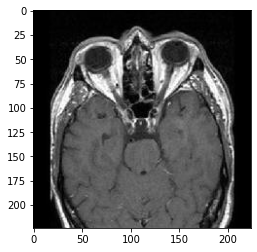

In [9]:
plt.imshow(X[0],cmap='gray')

In [10]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=10,test_size=0.20)
print("Shape of an image in x_train",x_train[0].shape)
print("Shape of an image in x_test",x_test[0].shape)

Shape of an image in x_train (224, 224, 3)
Shape of an image in x_test (224, 224, 3)


In [11]:
from sklearn import preprocessing 
import tensorflow as tf
le=preprocessing.LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)
y_train=tf.keras.utils.to_categorical(y_train,num_classes=2)
y_test=tf.keras.utils.to_categorical(y_test,num_classes=2)
y_train=np.array(y_train)
y_test=np.array(y_train)
x_train=np.array(x_train)
x_test=np.array(x_train)
print("Shape of x_train: ",x_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test: ",y_test.shape)

Shape of x_train:  (3910, 224, 224, 3)
Shape of x_test:  (3910, 224, 224, 3)
Shape of y_train:  (3910, 2)
Shape of y_test:  (3910, 2)


In [12]:
from keras.applications import vgg16

img_rows,img_cols=224,224

vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows,img_cols,3))

In [13]:
for layer in vgg.layers:
  layer.trainable=False

In [14]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
def lw(bottom_model,num_classes):
    top_model=bottom_model.output
    top_model=GlobalAveragePooling2D()(top_model)
    top_model=Dense(1024,activation='relu')(top_model)
    top_model=Dense(1024,activation='relu')(top_model)
    top_model=Dense(512,activation='relu')(top_model)
    top_model=Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [15]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.models import Model

In [16]:
import tempfile

def make_keras_picklable():
    def __getstate__(self):
        model_str=""
        with tempfile.NamedTemporaryFile(suffix=',hdf5',delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str=fd.read()
        d={'model_str':model_str}
        return d
    
    def __setstate__(self,state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5',delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model=load_model(fd.name)
        self.__dict__=model.__dict__
        
    cls=Model
    cls.__getstate__=__getstate__
    cls.setstate__=__setstate__

In [17]:
make_keras_picklable()

In [18]:
num_classes=2
FC_Head=lw(vgg,num_classes)
model=Model(inputs=vgg.input,outputs=FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [20]:
history=model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),verbose=1,initial_epoch=0)

Epoch 1/5
123/123 [==============================] - 1615s 13s/step - loss: 0.4498 - accuracy: 0.9263 - val_loss: 0.0350 - val_accuracy: 0.9918
Epoch 2/5
123/123 [==============================] - 1121s 9s/step - loss: 0.0436 - accuracy: 0.9854 - val_loss: 0.0173 - val_accuracy: 0.9939
Epoch 3/5
123/123 [==============================] - 3001s 25s/step - loss: 0.0252 - accuracy: 0.9913 - val_loss: 0.0413 - val_accuracy: 0.9849
Epoch 4/5
123/123 [==============================] - 1027s 8s/step - loss: 0.0443 - accuracy: 0.9841 - val_loss: 0.0295 - val_accuracy: 0.9880
Epoch 5/5
123/123 [==============================] - 2284s 19s/step - loss: 0.0218 - accuracy: 0.9918 - val_loss: 0.0077 - val_accuracy: 0.9964


In [21]:
import pickle
filename='brain_tumor_model.pkl'

In [22]:
pickle.dump(model,open(filename,'wb'))

In [23]:
load_model=pickle.load(open(filename,'rb'))

In [24]:
##Imagine you've trained a model that took hours or days to complete,
##and you want to save it for later use or share it with someone. 
##By saving the architecture in model.json and the weights in model.h5,
##you can later reload them to make predictions without retraining the model.

from tensorflow.keras.models import model_from_json
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
#seralize weights to HDF5
model.save_weights("model.h5")

In [25]:
#The goal of this code is to restore both the architecture and weights of a trained model from files (model.json and model.h5) 
##so that the model can be used for inference or further training without needing to retrain it from scratch.

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [26]:
loaded_model.predict(x_test)

123/123 [==============================] - 548s 4s/step


array([[6.7021447e-06, 9.9999332e-01],
       [1.0000000e+00, 5.4524122e-19],
       [3.4453169e-06, 9.9999654e-01],
       ...,
       [1.0000000e+00, 3.3679169e-15],
       [1.0665105e-04, 9.9989331e-01],
       [1.0000000e+00, 3.0601955e-11]], dtype=float32)

In [27]:
dec={0:'No Tumor', 1: 'Positive Tumor'}

1/1 [==============================] - 2s 2s/step


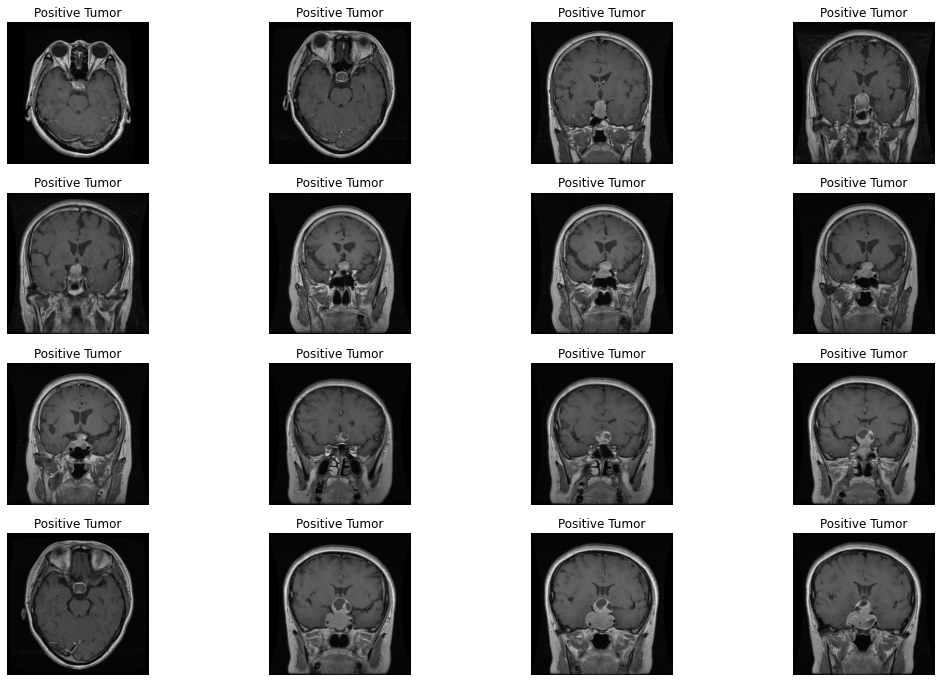

In [28]:
#This code reads 16 pituitary images from a directory, resizes them to 224x224 pixels, predicts whether each image represents a pituitary tumor using a trained model, 
##and then visualizes the images in a 4x4 grid along with their predicted labels.

plt.figure(figsize=(18,12))
p=os.listdir('D:/Projects/Brain_Tumour_Detection/Brain Tumor Data/Training/pituitary_tumor')
c=1
predict_img=[]
for i in os.listdir('D:/Projects/Brain_Tumour_Detection/Brain Tumor Data/Training/pituitary_tumor/')[:16]:
  plt.subplot(4,4,c)

  img=cv2.imread('D:/Projects/Brain_Tumour_Detection/Brain Tumor Data/Training/pituitary_tumor/'+i)
  img1 = cv2.resize(img,(224,224))
  predict_img.append(img1)
  p= load_model.predict(np.array(predict_img))
  result = np.argmax(p, axis =1)
  plt.title(dec[result[c-1]])
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  c+=1

1/1 [==============================] - 2s 2s/step


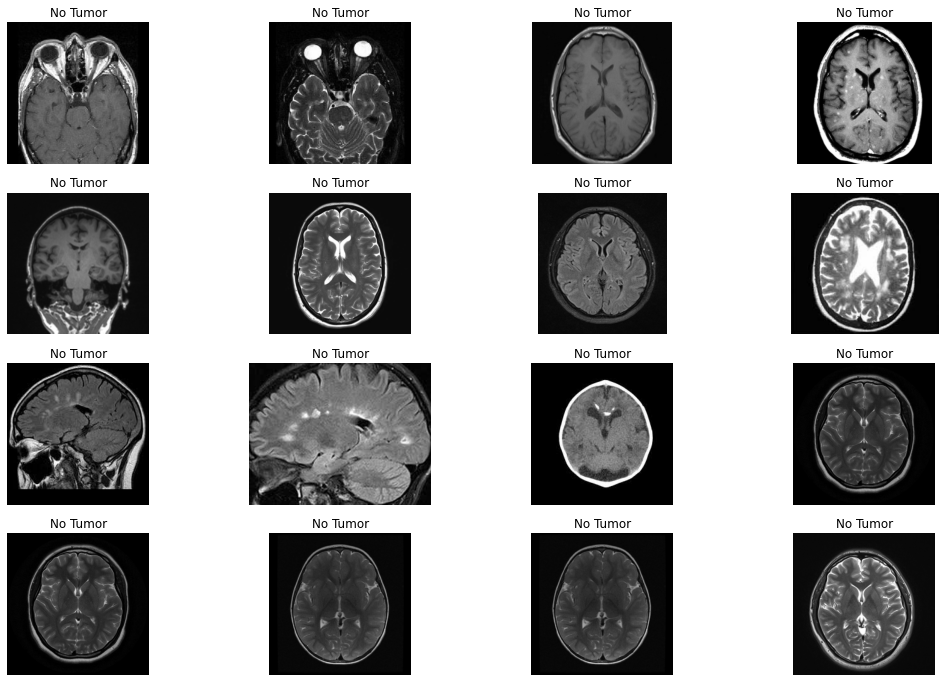

In [29]:
#This code reads 16 pituitary images from a directory, resizes them to 224x224 pixels, predicts whether each image represents a pituitary tumor using a trained model, 
##and then visualizes the images in a 4x4 grid along with their predicted labels.

plt.figure(figsize=(18,12))
p=os.listdir('D:/Projects/Brain_Tumour_Detection/Brain Tumor Data/Training/no_tumor')
c=1
predict_img=[]
for i in os.listdir('D:/Projects/Brain_Tumour_Detection/Brain Tumor Data/Training/no_tumor/')[:16]:
  plt.subplot(4,4,c)

  img=cv2.imread('D:/Projects/Brain_Tumour_Detection/Brain Tumor Data/Training/no_tumor/'+i)
  img1 = cv2.resize(img,(224,224))
  predict_img.append(img1)
  p= model.predict(np.array(predict_img))
  result = np.argmax(p, axis =1)
  plt.title(dec[result[c-1]])
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  c+=1
